# 2. Clustering particional

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from matplotlib import colors as mcolors


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, Birch, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples
import plotly.express as px




## 2.1 Preprocesamiento de datos

In [3]:
# primero importamos los csv scaled_df, normalized_df y df_grouped

scaled_df = pd.read_csv('scaled_df.csv')
normalized_df = pd.read_csv('normalized_df.csv')
df_grouped = pd.read_csv('df_grouped.csv')
df_prueba101_norm = pd.read_csv('df_prueba101_norm.csv')

El "preprocesamiento necesario para poder aplicar algoritmos de clustering particional" es básicamente la normalización de los datos ya que k-means se basa en distancias. En este caso, ya los hemos normalizado con MinMax scaler en el notebook anterior y por ello vamos a usar normalized_df en este notebook.

## 2.2 Número óptimo de clusters

#### Elbow method

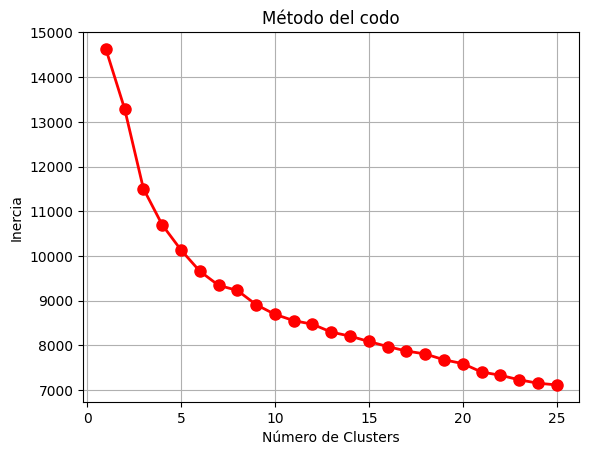

In [36]:
def plot_results(inertials):
   
    x, y = zip(*[inertia for inertia in inertials])
    plt.plot(x, y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del codo')
    plt.show()


def select_clusters_from_dataframe(df, loops, max_iterations, init_cluster, tolerance, random_state=20):
    
    # Convertir el dataframe a un array numpy
    points = df

    inertia_clusters = []

    for i in range(1, loops + 1):
        # Crear objeto KMeans
        kmeans = KMeans(
            n_clusters=i,
            max_iter=max_iterations,
            init=init_cluster,
            tol=tolerance,
            random_state=random_state
        )

        # Ajustar el modelo
        kmeans.fit(points)

        # Guardar el número de clusters y la inercia
        inertia_clusters.append([i, kmeans.inertia_])

    # Graficar los resultados
    plot_results(inertia_clusters)


# Parámetros constantes
LOOPS = 25
MAX_ITERATIONS = 10
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.00001

select_clusters_from_dataframe(
    df=normalized_df,  # Sustituye con tu dataframe
    loops=LOOPS,
    max_iterations=MAX_ITERATIONS,
    init_cluster=INITIALIZE_CLUSTERS,
    tolerance=CONVERGENCE_TOLERANCE
)


Esta gráfica da lugar a dudas sobre el número óptimo de clusters. Se observa un cambio pronunciado en la pendiente entre 3 y 5 clusters, a partir de 5 clusters la inercia disminuye más lentamente, indicando una posible saturación en la mejora de la partición. El número óptimo de clusters sugerido por este método es 4 o 5, ya que estos puntos reflejan el equilibrio entre una mejor separación y evitar el exceso de clusters.

#### Gap

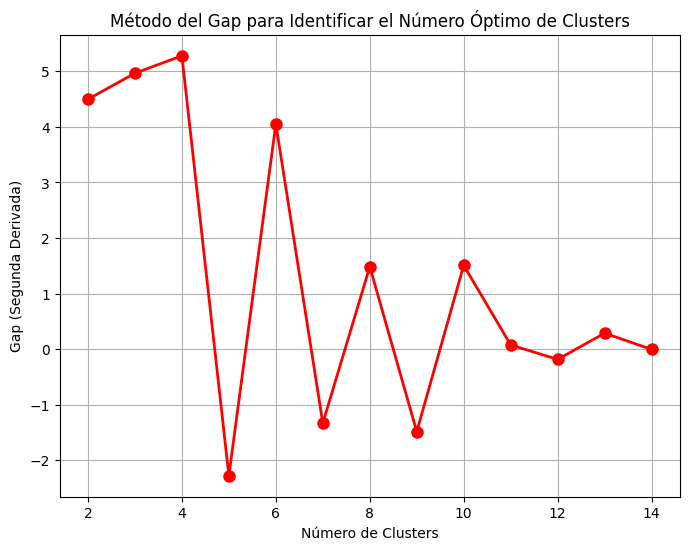

In [34]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

def plot_gap_from_dataframe(data):
    
    # Asegurarse de que los datos sean numéricos (sin columnas no válidas)
    points = data.select_dtypes(include=[np.number]).values

    # Calcular distancias jerárquicas entre puntos usando el método Ward
    Z = linkage(points, metric='euclidean', method='ward')

    # Obtener las últimas 10 distancias entre puntos o grupos
    last = Z[-15:, 2]
    num_clusters = np.arange(1, len(last) + 1)

    # Calcular el gap (segunda derivada de las distancias)
    gap = np.diff(last, n=2)  # Segunda diferencia (derivada discreta)

    # Visualizar el resultado
    plt.figure(figsize=(8, 6))
    plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
    plt.title('Método del Gap para Identificar el Número Óptimo de Clusters')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Gap (Segunda Derivada)')
    plt.grid(True)
    plt.show()


# Llamar a la función
plot_gap_from_dataframe(normalized_df)


Este método calcula la brecha entre la variabilidad observada en los datos originales y una referencia aleatoria, utilizando la segunda derivada para identificar picos. Los picos más altos indican el número óptimo de clusters.
Hay un pico significativo en el valor de gap en 4 clusters.
También hay fluctuaciones en valores secundarios para 6 y 10 clusters, pero estos son menos pronunciados.

Con la información de Elbow y Gap, podemos decir que el número óptimo de clusters sugerido por es claramente 4.

## 2.3 Calidad de clusters según k

In [37]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_clustering_with_k_and_quality_indices(data, k_range=range(2, 10), quality_indices=None):
    # Índices de calidad válidos
    valid_indices = ['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin']
    if quality_indices is None:
        quality_indices = ['inertia', 'silhouette']
    else:
        # Validar los índices solicitados
        for index in quality_indices:
            if index not in valid_indices:
                raise ValueError(f"Índice de calidad no válido. Elija entre {valid_indices}.")

    # Almacenar los valores de calidad para cada índice
    quality_scores = {index: [] for index in quality_indices}

    # Configurar la cuadrícula de visualización (3x3 para K-means)
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3 filas y 3 columnas
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for row, k in enumerate(k_range):
        col = row % 3  
        # Aplicar KMeans
        kmeans = KMeans(n_clusters=k, random_state=20)
        kmeans.fit(data)
        labels = kmeans.labels_

        # Calcular y almacenar los índices de calidad
        if 'inertia' in quality_indices:
            quality_scores['inertia'].append(kmeans.inertia_)
        if 'silhouette' in quality_indices:
            quality_scores['silhouette'].append(silhouette_score(data, labels))
        if 'calinski_harabasz' in quality_indices:
            quality_scores['calinski_harabasz'].append(calinski_harabasz_score(data, labels))
        if 'davies_bouldin' in quality_indices:
            quality_scores['davies_bouldin'].append(davies_bouldin_score(data, labels))

        # Reducir datos a 2D con PCA para visualización
        pca = PCA(n_components=2)
        data_2D = pca.fit_transform(data)

        # Gráfico de dispersión de clusters coloreados
        sns.scatterplot(
            x=data_2D[:, 0], y=data_2D[:, 1], hue=labels, 
            palette=sns.color_palette("tab10", k), ax=axes[row // 3, col], s=50, legend=None
        )
        axes[row // 3, col].set_title(f"K={k}")
        axes[row // 3, col].set_xlabel('Componente Principal 1')
        axes[row // 3, col].set_ylabel('Componente Principal 2')

    # Mostrar la primera figura (K-means 3x3)
    plt.tight_layout()
    plt.show()

    # Configurar subplots para índices de calidad en una sola fila
    fig, axes = plt.subplots(1, len(quality_indices), figsize=(5 * len(quality_indices), 5))
    if len(quality_indices) == 1:  # Si solo hay un índice, `axes` no será iterable
        axes = [axes]

    for ax, index in zip(axes, quality_indices):
        ax.plot(list(k_range), quality_scores[index], marker='o')
        ax.set_title(f"{index.replace('_', ' ').capitalize()}")
        ax.set_xlabel("Número de Clusters (K)")
        ax.set_ylabel(index.replace('_', ' ').capitalize())
        ax.grid(True)

    plt.tight_layout()
    plt.show()


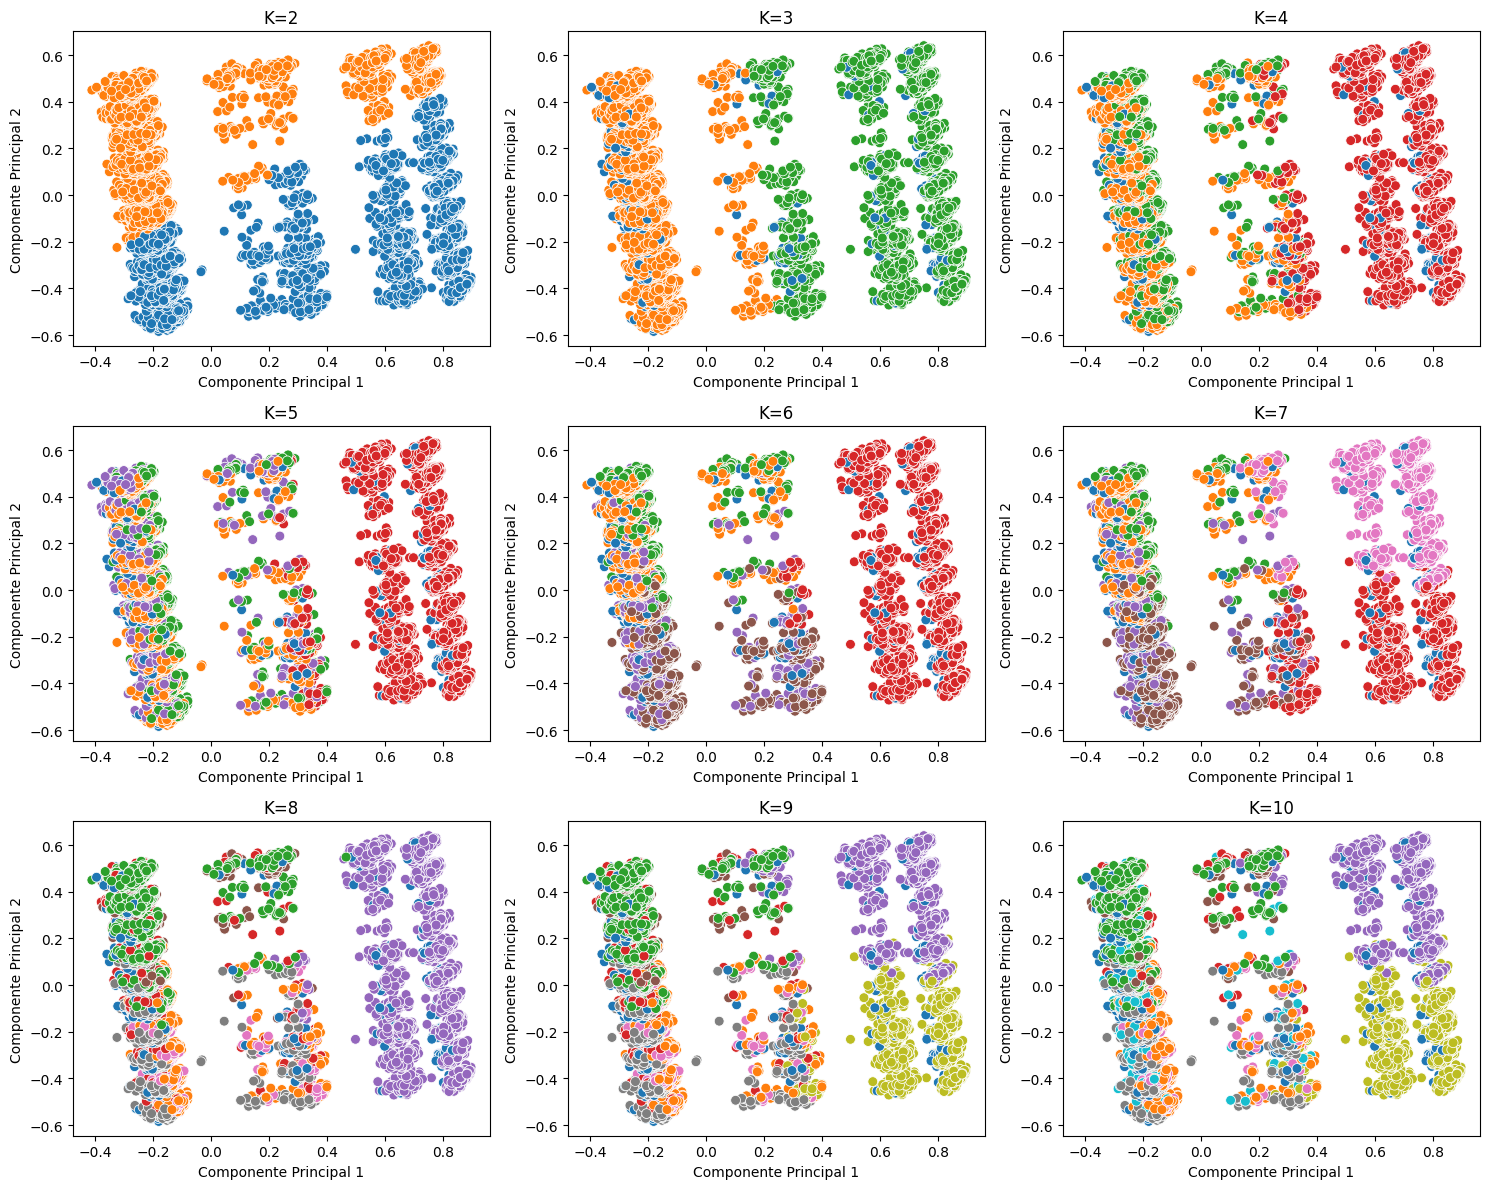

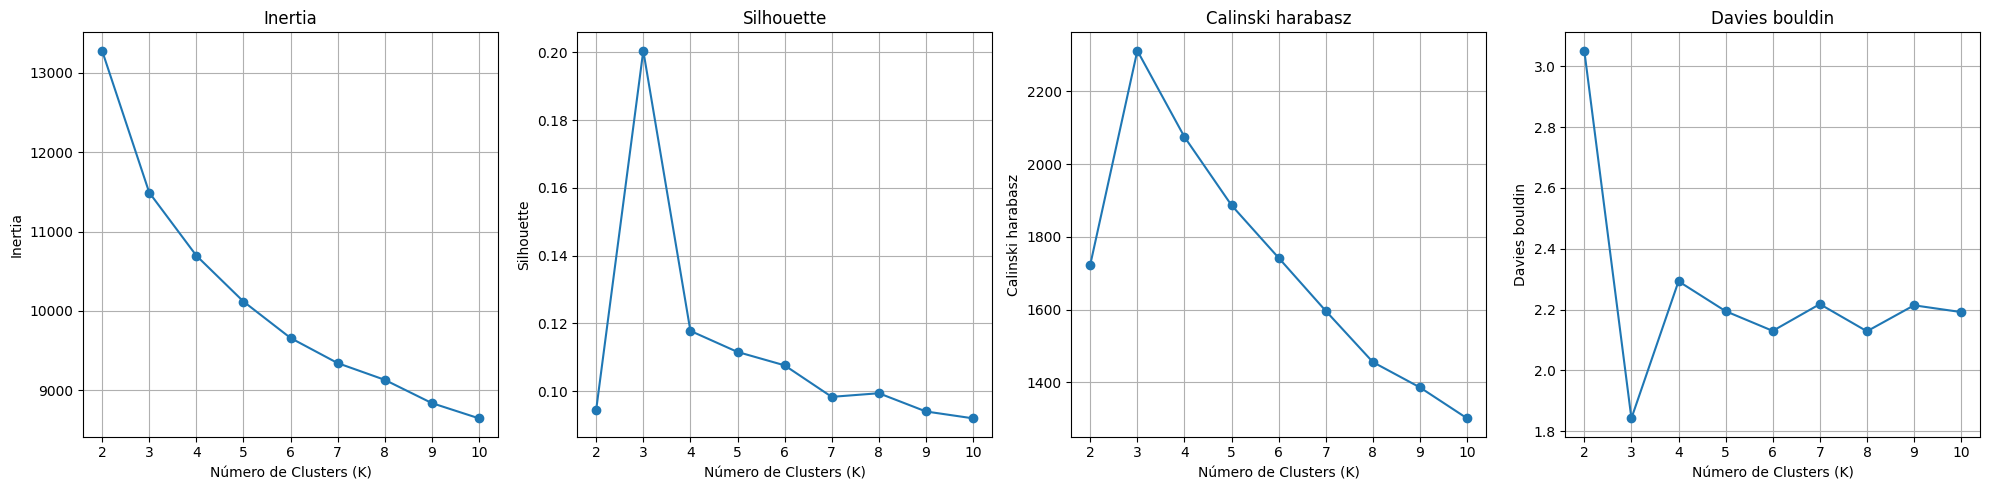

In [38]:
evaluate_clustering_with_k_and_quality_indices(normalized_df, k_range=range(2, 11), quality_indices=['inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'])

Las gráficas muestran cómo evolucionan los clusters con k:
- En k=2, los clusters están bien definidos pero no parecen adaptarse adecuadamente a la naturaleza del dataframe.
- En k=3, se observan grupos mejor adaptados, pero con muchos puntos que permanecen no son clasificados adecuadamente.
- En k=4, los clusters son menos claros y se introduce más ruido del esperado.
- Para k>4, los clusters comienzan a dividirse en demasiados subgrupos poco definidos, introduciendo ruido y redundancia.

De los índices podemos observar lo siguiente: 
- La inercia disminuye a medida que aumenta k, lo cual es esperado porque al aumentar el número de clusters, los puntos están más cerca de sus centroides.
Entre k=3 y k=4, la disminución de la inercia es significativa (11500 a 10800). Sin embargo, después de k=4, la disminución es menor, lo que confirma que k=4 es un buen punto de equilibrio pero no demiente que k=3 también lo sea.
- Se ve una clara predominancia en k=3 y una mejora en el índice de silhouette. Esto nos lleva a replantearnos el número óptimo de clusters.
- Como k=3 tiene el valor más alto de Calinski, reforzamos la idea de cambiar el número óptimo de clusters. Es un valor bastante alto y supuestamente sugiere que los clusters son densos y bien separados. No obstante no podemos obviar la mala puntuación de silhouette.
- El índice Davies-Bouldin sugiere que k=4 no es ideal en términos de compacidad, por ello y apoyando en el resto de métricas, podemos concluir que k=3 es la mejor elección.


## 2.4 Obtención de información de clusters

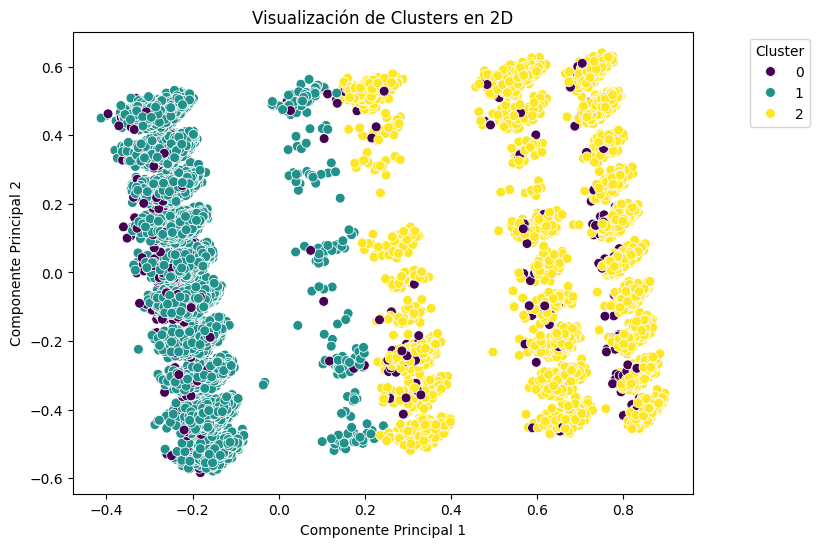

In [40]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Parámetros de K-Means
k = 3
random_state = 20  # Para reproducibilidad

# Inicialización y ajuste del modelo K-Means
kmeans = KMeans(n_clusters=k, random_state=random_state)
kmeans.fit(normalized_df)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Aplicar PCA para reducir a 2 dimensiones
pca_2D = PCA(n_components=2)
X_2D = pca_2D.fit_transform(normalized_df)

# Visualización en 2D con colores según los clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_2D[:, 0], 
    y=X_2D[:, 1], 
    hue=labels, 
    palette='viridis', 
    s=50
)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters en 2D')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


In [41]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Número de clusters que deseas (k)
k = 3  

# Inicialización del modelo KMeans
kmeans = KMeans(n_clusters=k, random_state=42)

# Ajustar el modelo KMeans al DataFrame normalizado
kmeans.fit(normalized_df)

# Obtener las etiquetas (clusters asignados)
labels = kmeans.labels_

# Añadir las etiquetas de los clusters al DataFrame copiado
df_grouped['Cluster'] = labels


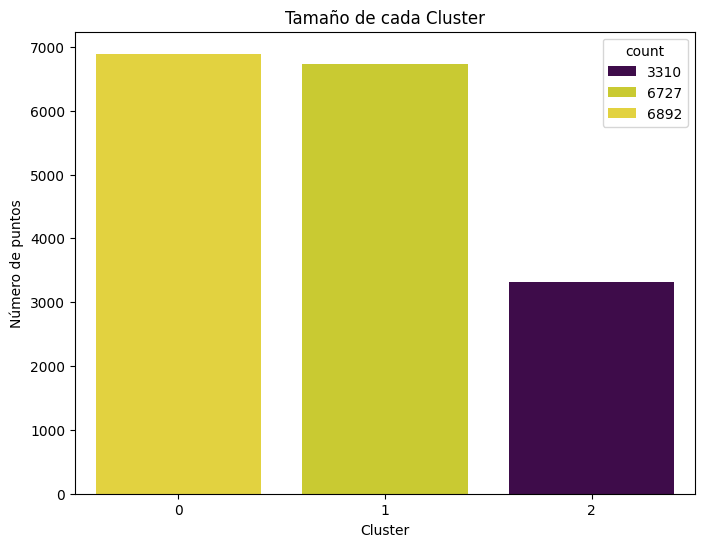

In [43]:
plt.figure(figsize=(8, 6))
cluster_sizes = df_grouped['Cluster'].value_counts()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values, palette='viridis', hue=cluster_sizes)
plt.title('Tamaño de cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de puntos')
plt.show()

Clusters de tamaños desbalanceados podría ser un signo de agrupaciones desequilibradas o incluso de ruido en los datos. En este caso el cluster 2 es proporcionalmente más pequeño que los otros dos clusters.

Como vamos a analizar a los viajeros, nos interesan solo las columnas de sexo, tipo de persona y edad.

In [44]:

def calculate_distributions(df_grouped, labels):
    # Inicializa un diccionario para almacenar las distribuciones por cluster
    distributions = {}

    # Columnas numéricas para la distribución
    numeric_columns = ['sexo_Mujer', 'sexo_Hombre', 'sexo_Desconocido',
                       'rango_edad_0', 'rango_edad_0-17',
                       'rango_edad_18-24', 'rango_edad_25-34', 'rango_edad_35-44',
                       'rango_edad_45-59', 'rango_edad_60+', 'tipo_persona_Conductor',
                       'tipo_persona_Pasajero', 'tipo_persona_Peatón']

    

    # Inicializar un DataFrame vacío para cada columna numérica por cluster
    for col in numeric_columns:
        distributions[col] = pd.DataFrame(0, index=np.unique(labels), columns=[col])

    # Calcular la distribución por cluster
    for idx, label in enumerate(np.unique(labels)):
        cluster_data = df_grouped[labels == label]
        for col in numeric_columns:
            distributions[col].loc[label, col] = cluster_data[col].sum()

    return distributions


def plot_numeric_distributions(distributions):
    # Obtener los índices únicos de las distribuciones
    unique_indices = distributions[next(iter(distributions))].index

    for cluster in unique_indices:
        fig, ax = plt.subplots(figsize=(12, 6))

        col_names = list(distributions.keys())
        sums = [dist.loc[cluster].values[0] for col, dist in distributions.items()]

        colors = list(mcolors.TABLEAU_COLORS.values())

        ax.bar(col_names, sums, color=colors[:len(col_names)], alpha=0.7)

        for i, v in enumerate(sums):
            ax.text(i, v + max(sums) * 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

        ax.set_ylim(0, max(sums) * 1.1)

        ax.set_title(f'Suma de valores por columna numérica para Cluster {cluster}', fontsize=14)
        ax.set_ylabel('Suma', fontsize=12)
        ax.set_xlabel('Columnas', fontsize=12)
        ax.set_xticks(range(len(col_names)))
        ax.set_xticklabels(col_names, rotation=45, ha='right', fontsize=10)

        plt.tight_layout()
        plt.show()



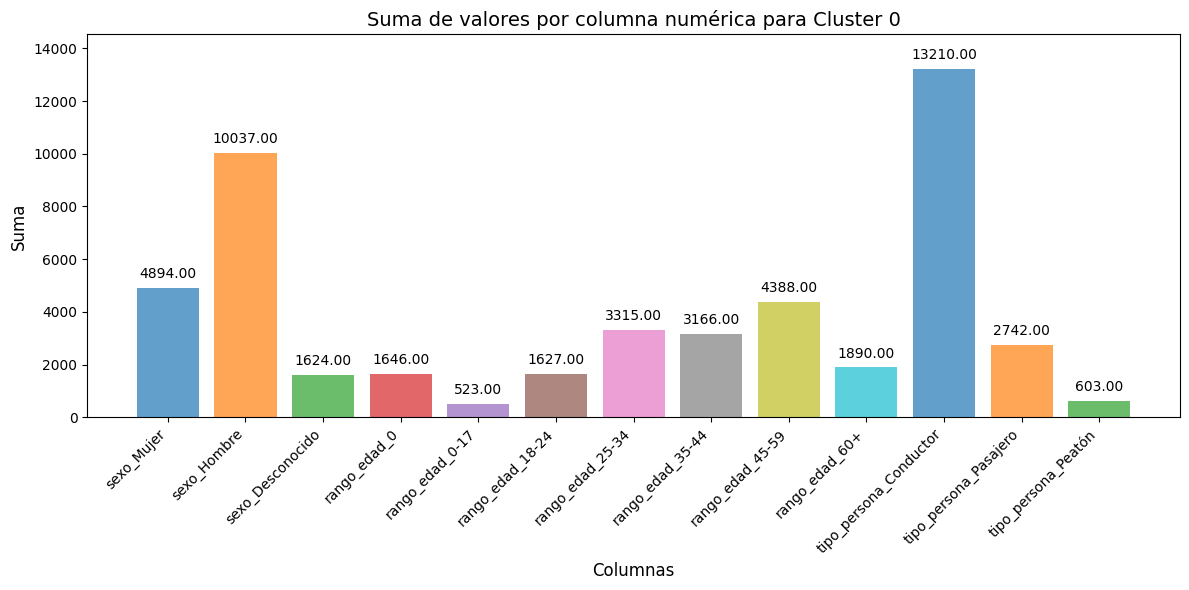

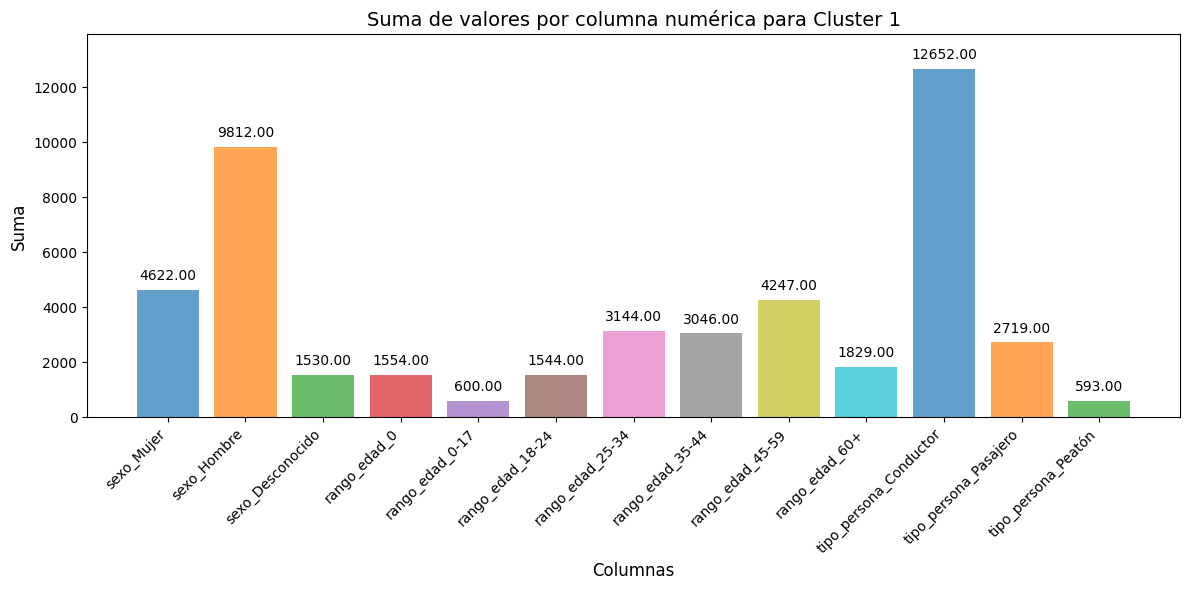

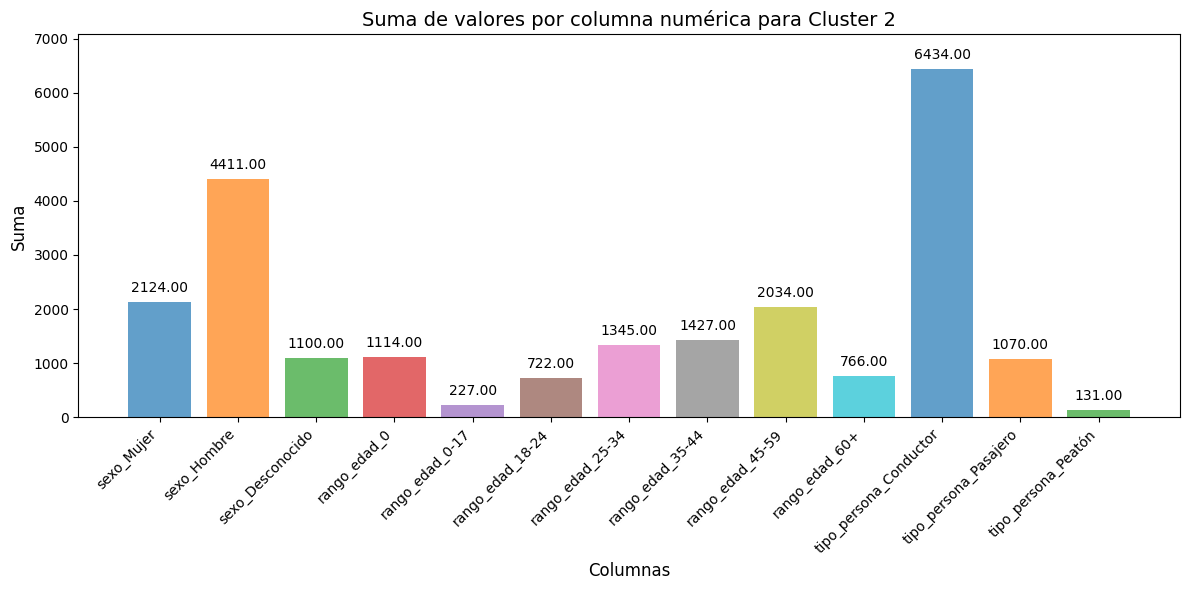

In [45]:
distributions = calculate_distributions(df_grouped, labels)
plot_numeric_distributions(distributions)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def calculate_distributions_percentage(df_grouped, labels):
    # Inicializa un diccionario para almacenar las distribuciones por cluster
    distributions = {}

    # Columnas numéricas para la distribución
    numeric_columns = ['sexo_Mujer', 'sexo_Hombre', 'sexo_Desconocido',
                       'rango_edad_0', 'rango_edad_0-17',
                       'rango_edad_18-24', 'rango_edad_25-34', 'rango_edad_35-44',
                       'rango_edad_45-59', 'rango_edad_60+', 'tipo_persona_Conductor',
                       'tipo_persona_Pasajero', 'tipo_persona_Peatón']

    # Inicializa las columnas numéricas con valores adecuados
    for col in numeric_columns:
        distributions[col] = pd.DataFrame(0.0, index=np.unique(labels), columns=[col])  # Inicializa con float64

    # Calcular el total global de cada tipo de vehículo (sobre todos los clusters)
    total_mujeres = df_grouped['sexo_Mujer'].sum()
    total_hombres = df_grouped['sexo_Hombre'].sum()
    total_desconocidos = df_grouped['sexo_Desconocido'].sum()
    total_edad_0 = df_grouped['rango_edad_0'].sum()
    total_edad_0_17 = df_grouped['rango_edad_0-17'].sum()
    total_edad_18_24 = df_grouped['rango_edad_18-24'].sum()
    total_edad_25_34 = df_grouped['rango_edad_25-34'].sum()
    total_edad_35_44 = df_grouped['rango_edad_35-44'].sum()
    total_edad_45_59 = df_grouped['rango_edad_45-59'].sum()
    total_edad_60 = df_grouped['rango_edad_60+'].sum()
    total_conductores = df_grouped['tipo_persona_Conductor'].sum()
    total_pasajeros = df_grouped['tipo_persona_Pasajero'].sum()
    total_peatones = df_grouped['tipo_persona_Peatón'].sum()
    equivalencias = [total_mujeres, total_hombres, total_desconocidos,
                      total_edad_0, total_edad_0_17, total_edad_18_24, 
                      total_edad_25_34, total_edad_35_44, total_edad_45_59, 
                      total_edad_60, total_conductores, total_pasajeros,
                        total_peatones]

    # Calcular la distribución por cluster
    for idx, label in enumerate(np.unique(labels)):
        cluster_data = df_grouped[labels == label]
        
        for i, col in enumerate(numeric_columns):
            distributions[col].loc[label, col] = (cluster_data[col].sum() / equivalencias[i]) * 100
              
    return distributions


def plot_distributions_percentage(distributions):
    # Obtener los índices únicos de las distribuciones
    unique_indices = distributions[next(iter(distributions))].index

    for cluster in unique_indices:
        fig, ax = plt.subplots(figsize=(12, 6))

        col_names = list(distributions.keys())
        percentages = []
        cod_distritos = []

        # Filtrar solo las columnas numéricas para el gráfico
        for col, dist in distributions.items():
            value = dist.loc[cluster].values[0]
            percentages.append(value) 

        # Crear colores para las barras
        colors = list(mcolors.TABLEAU_COLORS.values())

        # Graficar las barras
        ax.bar(col_names[:len(percentages)], percentages, color=colors[:len(percentages)], alpha=0.7)

        # Añadir los valores sobre las barras
        for i, v in enumerate(percentages):
            ax.text(i, v + max(percentages) * 0.02, f'{v:.2f}%', ha='center', va='bottom', fontsize=10)

        ax.set_ylim(0, 100)

        # Incluir los cod_distritos en el título
        ax.set_title(f'Porcentaje de valores por columna numérica para Cluster {cluster} (cod_distritos: {", ".join(cod_distritos)})', fontsize=14)
        ax.set_ylabel('Porcentaje', fontsize=12)
        ax.set_xlabel('Columnas', fontsize=12)
        ax.set_xticks(range(len(percentages)))
        ax.set_xticklabels(col_names[:len(percentages)], rotation=45, ha='right', fontsize=10)

        plt.tight_layout()
        plt.show()


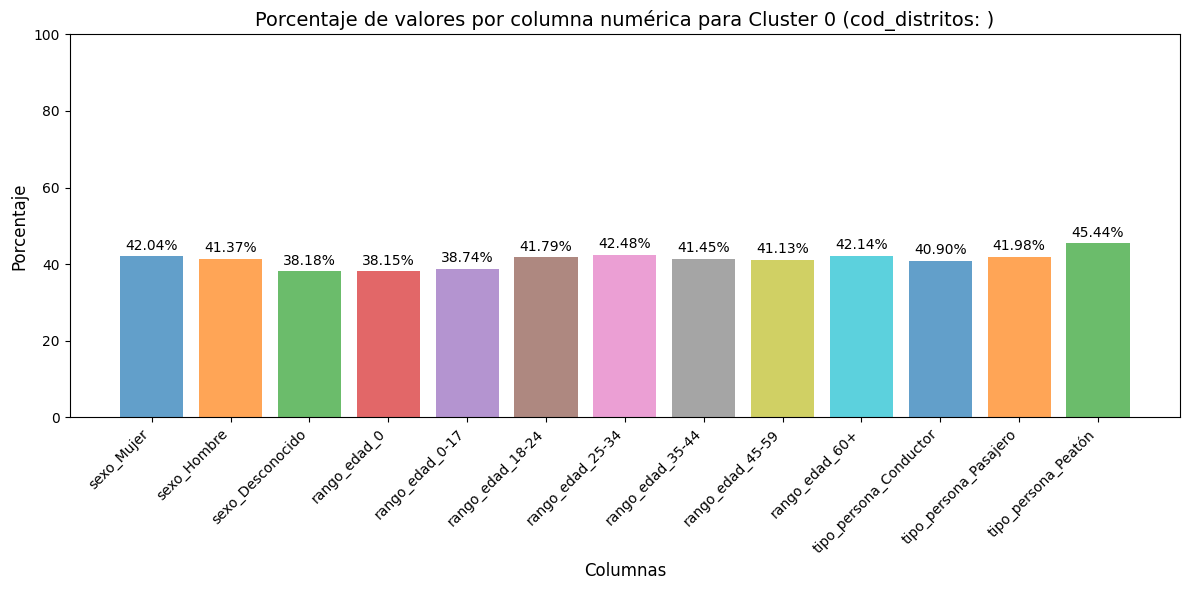

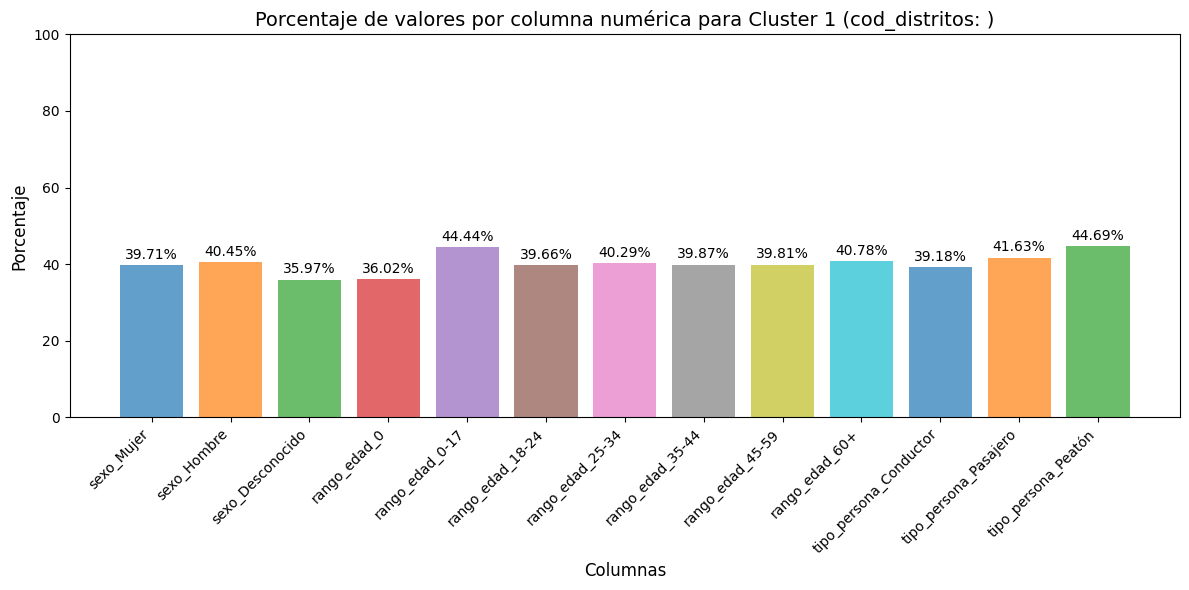

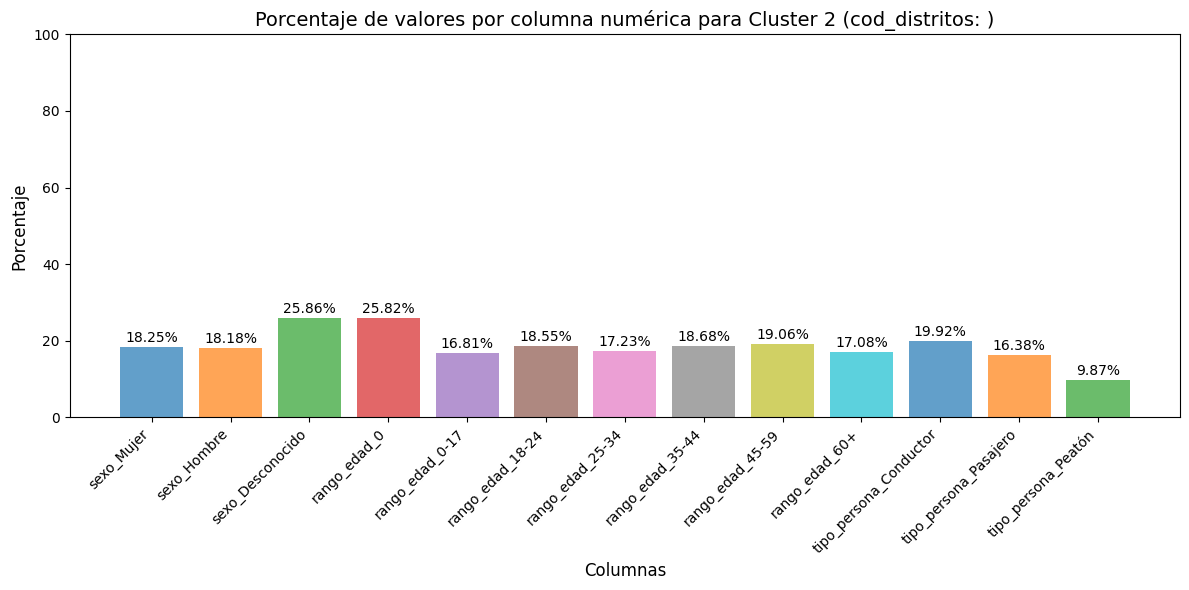

In [48]:
percentages = calculate_distributions_percentage(df_grouped, labels)
plot_distributions_percentage(percentages)

Las gráficas de barras muestran la distribución de las variables categóricas en cada cluster. Se observa que todos los clusters tienen una distribución demasiado similar y no se distingue un patrón claro que los diferencie. Esto sugiere que los clusters no están bien definidos y que la segmentación no es adecuada o que los datos están demasiado desbalaceados para las características de las columnas.

## Comparación de resultados

Desgraciadamente con ambos algoritmos nos han salido clusters demasiado generalistas y poco específicos. En el caso de k-means hemos obtenido índices mucho más bajos en silhouette pese a estar utilizando un dataframe más cercano a las distribuciones esféricas que requiere k-means. En el caso de clustering jerárquico, hemos obtenido clusters con tamaños mucho más desbalanceados pero igualmente con una distribución de variables categóricas similar entre ellos.

Por otro lado, BIRCH nos llegó a dar buenos valores para los índices pero nos generaba un número muy elevado de clustes, lo que nos impedía poder analizarlos de manera individual.

##### Ventajas y desventajas de ambos algoritmos

La primera diferencia que podemos apreciar es que el clustering jerárquico no necesita un número de clusters como parámetro en cambio, el k-means sí. Al trabajar con diferentes linkages y distancias hemos podido ver que el jerárquico trabaja mejor con datos circulares y agrupados naturalmente que con datos más densos y mensos dispersos. Los diferentes parámetros que acepta, da la posibilidad de ajustar el clustering a los datos. Además una ventaja es que los resultados son reproducibles y no dependen de un random_state para obtener los mismos resultados.
Como desventaja, el jerárquico es más lento y los dendrogramas que genera pueden llegar a ser difíciles de interpretar, sobretodo cuando las agrupaciones son complejas. 

Por otro lado, k-means es más rápido y tiene un funcionamiento más dinámico por su capacidad de ajustarse iterativamente. Está recomendado para datasets más grandes de los que el jerárquico es capaz de procesar. Sin embargo, necesita que los datos estén normalizados, que se establezca el número de clusters de antemano, asume que los clusters son esféricos y es muy sensible a outliers y al ruido.

En resumen, para datos pequeños y o de formas complejas, el jerárquico es más recomendable. Para datos más grandes pero casi obligatoriamente esféricos, el k-means es más adecuado.